In [16]:
%pylab inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz

Populating the interactive namespace from numpy and matplotlib


/u/wangnisn/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [17]:
import pde
import matplotlib.pyplot as plt
import numpy as np 
import gplearn
from sklearn.model_selection import train_test_split

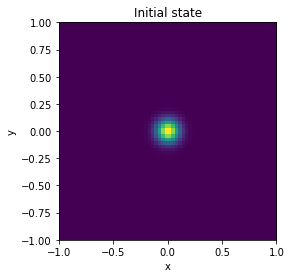

In [48]:
grid = pde.CartesianGrid([[-1, 1], [-1, 1]], 64)
dx = dy = 2./64
state = pde.ScalarField.from_expression(grid, 'exp(-(x**2 + y**2) * 100)')
state.plot(title='Initial state');

In [35]:
eq = pde.DiffusionPDE(diffusivity=0.5)
dt = 1e-4
storage = pde.MemoryStorage()
result = eq.solve(state, t_range=1, dt=dt, tracker=storage.tracker(1*dt))

In [36]:
operator = state.grid.get_operator("laplace", bc='natural')
def get_laplace(u,dx,dy):
    #u_x = np.gradient(u,dx, axis=1)
    #u_y = np.gradient(u,dy, axis=2)
    #u_xx = np.gradient(u_x,dx, axis=1)
    #u_yy = np.gradient(u_y, dy, axis=2)
    #laplace = u_xx + u_yy
    #return laplace
    laplace = []
    for d in u:
        laplace.append(operator(d))
    laplace = np.array(laplace)
    return laplace

In [37]:
u = storage.data
u = np.array(u)
laplace = get_laplace(u,dx,dy)
u_t = np.gradient(u,dt,axis=0)
# remove boundary pixels
u = u[:,2:-2,2:-2].flatten()
laplace = laplace[:,2:-2,2:-2].flatten()
u_t = u_t[:,2:-2,2:-2].flatten()
ind = np.random.choice(np.arange(len(u)),size=10000,replace=False)
u = u[ind]
laplace = laplace[ind]
u_t = u_t[ind]

x_train = np.vstack((laplace,u)).T
y_train = u_t
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.33, random_state=0)

In [38]:
np.mean(y_train / x_train[:,0])

0.4994142018099034

In [39]:
model = gplearn.genetic.SymbolicRegressor(population_size=5000,
                           generations=100, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [40]:
model.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13      2.65948e+08        3       0.00028472      0.000301331     12.02m


SymbolicRegressor(generations=100, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [41]:
print (model._program)

mul(X0, 0.496)


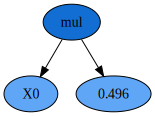

In [44]:
dot_data = model._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph